In [ ]:
# Using Simpy simulator
# 102303729

!pip install simpy

In [9]:
import simpy
import random
import numpy as np

def queue_simulation(arrival_rate, service_time, servers, sim_time=200):

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=servers)

    wait_times = []

    def customer(env):
        arrival = env.now

        with server.request() as req:
            yield req

            wait = env.now - arrival
            wait_times.append(wait)

            service = random.expovariate(1.0 / max(service_time, 0.1))
            yield env.timeout(service)

    def arrival_process(env):
        while True:
            yield env.timeout(random.expovariate(max(arrival_rate, 0.1)))
            env.process(customer(env))

    env.process(arrival_process(env))
    env.run(until=sim_time)

    if len(wait_times) == 0:
        return {
            "avg_wait": 0,
            "max_wait": 0,
            "customers": 0
        }

    return {
        "avg_wait": float(np.mean(wait_times)),
        "max_wait": float(max(wait_times)),
        "customers": int(len(wait_times))
    }


In [10]:
# Testing one simulation
result = queue_simulation(
    arrival_rate=3,
    service_time=2,
    servers=2
)

print(result)


{'avg_wait': 68.96742352464372, 'max_wait': 127.18033129451271, 'customers': 226}


In [11]:
def random_parameters():
    return {
        "arrival_rate": random.uniform(1,10),
        "service_time": random.uniform(1,8),
        "servers": random.randint(1,5)
    }


In [12]:
import pandas as pd

data = []

for i in range(1000):

    p = random_parameters()

    out = queue_simulation(
        p["arrival_rate"],
        p["service_time"],
        p["servers"]
    )

    row = {
        "arrival_rate": p["arrival_rate"],
        "service_time": p["service_time"],
        "servers": p["servers"],
        "avg_wait": out.get("avg_wait", 0),
        "max_wait": out.get("max_wait", 0),
        "customers": out.get("customers", 0)
    }

    data.append(row)

df = pd.DataFrame(data)
df.head()


,arrival_rate,service_time,servers,avg_wait,max_wait,customers
0,2.514997,3.148152,2,75.798790,147.998464,135
1,3.238554,5.709907,4,71.493219,161.456442,133
2,9.934449,7.543335,4,88.970272,186.295647,110
3,9.024683,1.692955,4,72.017593,146.905635,506
4,6.818064,2.226549,3,81.987280,159.563288,268


In [13]:
# Step 6 Comparing Different Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[["arrival_rate", "service_time", "servers", "customers"]]
y = df["avg_wait"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


In [15]:
models = {
 "Linear Regression": LinearRegression(),
 "Decision Tree": DecisionTreeRegressor(),
 "Random Forest": RandomForestRegressor(n_estimators=100),
 "SVR": SVR(),
 "KNN": KNeighborsRegressor(),
 "MLP": MLPRegressor(max_iter=500),
 "XGBoost": XGBRegressor()
}


In [19]:
results = []

for name, model in models.items():

    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)

    results.append([name, mae, rmse, r2])


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
result_df = pd.DataFrame(results,
        columns=["Model","MAE","RMSE","R2"])

result_df.sort_values("R2", ascending=False)


,Model,MAE,RMSE,R2
2,Random Forest,4.940609,6.583424,0.917524
6,XGBoost,5.686812,7.533125,0.892013
4,KNN,5.899527,8.096759,0.875249
1,Decision Tree,6.660145,9.219398,0.838256
5,MLP,7.075481,9.294865,0.835598
3,SVR,7.679595,11.968500,0.727415
0,Linear Regression,9.928117,12.752815,0.690519


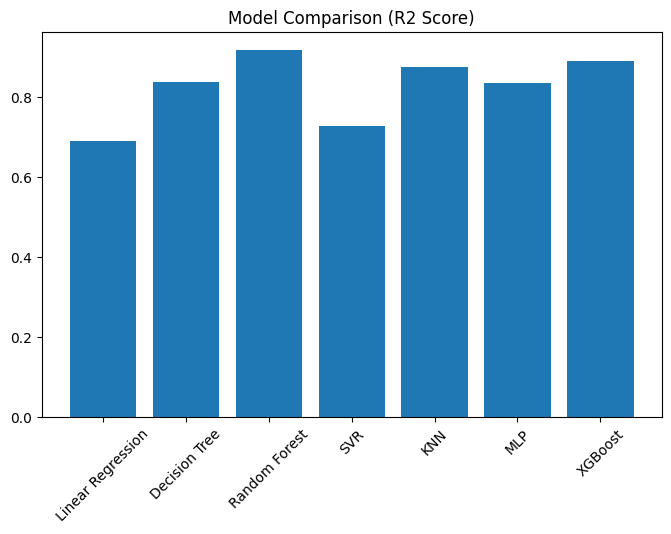

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(result_df["Model"], result_df["R2"])
plt.title("Model Comparison (R2 Score)")
plt.xticks(rotation=45)
plt.show()
